In [1]:
import cirq
import qiskit
from qiskit.qasm3 import loads
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, Aer
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler import generate_preset_pass_manager
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
    kraus_error
)

from qiskit_ionq import IonQProvider

import cirq_ionq
from cirq_ionq.ionq_native_gates import GPIGate, GPI2Gate, MSGate

# import qibo
# qibo.set_backend("numpy")

import tequila as tq
import numpy as np
import copy
import sys
import os
import time

import matplotlib.pyplot as plt

sys.path.append('../../../../Gates_Lab_Suite')
sys.path.append('../../utils')

from hamiltonian_reduction import (
    reduce_measurements_naive
)

from simulation_tools import (
    get_energy_from_data,
    simulate_data_cirq,
    get_measurement_dict_from_H,
    get_energy_from_expectation_values,
    get_energy_from_data,
    convert_tq_H_to_cirq_H,
    convert_tq_H_to_dict_H,
    convert_population_data_to_expectation_values,
    get_qiskit_pauli_list_from_tq_H,
    build_ionq_noise_model)

/home/liamj/Molecular Simulation/teq-beta-env/lib/python3.12/site-packages/tequila/simulators/simulator_api.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Jordan Wigner Transformation

In [2]:
# Define the geometry
g = "h 0.0 0.0 0.0\nh 0.0 0.0 1.5\nh 0.0 0.0 3.0\nh 0.0 0.0 4.5"

# Get molecule
mol_JW = tq.Molecule(backend="pyscf", geometry=g, basis_set="sto-3g", transformation="JordanWigner").use_native_orbitals()

In [3]:
print('HF ', mol_JW.compute_energy('HF'))
fci = mol_JW.compute_energy('FCI')
print('FCI ', fci)

/home/liamj/Molecular Simulation/teq-beta-env/lib/python3.12/site-packages/pyscf/gto/mole.py:1300: UserWarning: Function mol.dumps drops attribute energy_nuc because it is not JSON-serializable
  warnings.warn(msg)


HF  -1.82913741244302
FCI  -1.9961503255188089


### Method 1: G1 SPA

In [7]:
U_JW_SPA = mol_JW.make_ansatz("SPA", edges=[(0,1),(2,3)])
H_JW_G1 = mol_JW.make_hamiltonian()

# Unitary for two orbital rotations (parameterized by 'a' and 'b')
U0 = mol_JW.UR(0,1,'a') + mol_JW.UR(2,3,'b')
U_JW_G1 = U0 + U_JW_SPA + U0.dagger()

res = tq.minimize(tq.ExpectationValue(H=H_JW_G1, U=U_JW_G1), silent=True)

U_JW_G1_mapped = U_JW_G1.map_variables(variables=res.variables)

for gate in U_JW_G1_mapped.gates:
    try:
        if not isinstance(gate.parameter, tq.objective.objective.Variable):
            gate.parameter = gate.parameter.transformation(gate.parameter.args[0])
    except:
        x = 1

cirq_JW_G1_parameterized = tq.compile(U_JW_G1, backend="cirq").circuit
qiskit_JW_G1_parameterized_variables_raw = tq.compile(U_JW_G1, backend="qiskit")
qiskit_JW_G1_parameterized_variables = qiskit_JW_G1_parameterized_variables_raw.circuit


cirq_JW_G1 = tq.compile(U_JW_G1_mapped, backend="cirq").circuit
qiskit_JW_G1 = tq.compile(U_JW_G1_mapped, backend="qiskit").circuit
# qiskit_JW_G1 = qiskit.QuantumCircuit.from_qasm_str(cirq.qasm(cirq_JW_G1))

# Assign all parameters except one:
all_params = qiskit_JW_G1_parameterized_variables.parameters

param_mapping = {}

for param, obj in qiskit_JW_G1_parameterized_variables_raw.pars_to_tq.items():
    if 'f((a,))' in param.name:
        param_mapping[param] = obj.transformation(res.variables['a'])
    elif 'f((b,))' in param.name:
        param_mapping[param] = obj.transformation(res.variables['b'])
    elif 'f((((0, 1)' in param.name:
        param_mapping[param] = res.variables[list(dict(res.variables).keys())[2]]
    elif 'f((((2, 3)' in param.name:
        param_mapping[param] = res.variables[list(dict(res.variables).keys())[3]]

qiskit_JW_G1_parameterized = qiskit_JW_G1_parameterized_variables.assign_parameters(param_mapping)

energy_JW_G1 = res.energy
print(f"difference from fci: {abs(res.energy-fci)*1000} mH")

# print(f"Original number of measurements: {len(H_JW_G1.keys())}")
# reduced_measurements_JW_G1 = reduce_measurements_naive(H_JW_G1, 8)
# print(f"Reduced number of measurements: {len(reduced_measurements_JW_G1)}")

difference from fci: 39.89570428503164 mH


### Method 2: G1 SPA with optimized orbitals

In [5]:
# If u want regular obrital optimization u can use:
guess = np.eye(4)
opt = tq.quantumchemistry.optimize_orbitals(molecule=mol_JW,circuit=U_JW_SPA, initial_guess=guess, silent=True).molecule
H_JW_G1_optimized_orbitals = opt.make_hamiltonian()
res = tq.minimize(tq.ExpectationValue(H=H_JW_G1_optimized_orbitals,U=U_JW_SPA), silent=True)

U_JW_G1_optimized_orbitals_fixed_params = U_JW_SPA.map_variables(variables=res.variables)
cirq_JW_G1_optimized_orbitals = tq.compile(U_JW_G1_optimized_orbitals_fixed_params, backend="cirq").circuit
qiskit_JW_G1_optimized_orbitals = tq.compile(U_JW_G1_optimized_orbitals_fixed_params, backend="qiskit").circuit
# qiskit_JW_G1_optimized_orbitals = qiskit.QuantumCircuit.from_qasm_str(cirq.qasm(cirq_JW_G1_optimized_orbitals))

print(f"difference from fci: {abs(res.energy-fci)*1000} mH\n")
energy_JW_G1_optimized_orbitals = res.energy

# print(f"Original number of measurements: {len(H_JW_G1_optimized_orbitals.keys())}")
# reduced_measurements_JW_G1_optimized_orbitals = reduce_measurements_naive(H_JW_G1_optimized_orbitals, 8)
# print(f"Reduced number of measurements: {len(reduced_measurements_JW_G1_optimized_orbitals)}")

difference from fci: 16.26244097546148 mH



### Method 3: G2

In [6]:
# If u want to use Orbital Correlator for more graphs eg. (1,2) u can use:
U1 = mol_JW.UR(1,2,'c')
UC = mol_JW.UC(1,2,'d')
U_JW_G2 = U_JW_SPA + U0 + U1 + UC + U0.dagger() + U1.dagger()
res = tq.minimize(tq.ExpectationValue(H=H_JW_G1,U=U_JW_G2), silent=True)

U_JW_G2_mapped = U_JW_G2.map_variables(variables=res.variables)

for gate in U_JW_G2_mapped.gates:
    try:
        if not isinstance(gate.parameter, tq.objective.objective.Variable):
            gate.parameter = gate.parameter.transformation(gate.parameter.args[0])
    except:
        x = 1

cirq_JW_G2 = tq.compile(U_JW_G2_mapped, backend="cirq").circuit
qiskit_JW_G2 = tq.compile(U_JW_G2_mapped, backend="qiskit").circuit
# qiskit_JW_G2 = qiskit.QuantumCircuit.from_qasm_str(cirq.qasm(cirq_JW_G2))

print(f"difference from fci: {abs(res.energy-fci)*1000} mH\n")
energy_JW_G2 = res.energy

# print(f"Original number of measurements: {len(H_JW_G1.keys())}")
# reduced_measurements_JW_G2 = reduce_measurements_naive(H_JW_G1, 8)
# print(f"Reduced number of measurements: {len(reduced_measurements_JW_G2)}")

difference from fci: 16.69940439853579 mH



### Method 4: G2 with optimized Orbitals

In [23]:
U_JW_G2_optimized_orbitals = U_JW_SPA
U_JW_G2_optimized_orbitals += mol_JW.UR(0,2, angle=(tq.Variable("a_1") + 0.5) * np.pi) + mol_JW.UR(1,3, angle=(tq.Variable("a_2") + 0.5) * np.pi)
U_JW_G2_optimized_orbitals += mol_JW.UC(0,2, angle=tq.Variable("b_1") * np.pi) + mol_JW.UC(1,3, angle=tq.Variable("b_2") * np.pi)
U_JW_G2_optimized_orbitals += mol_JW.UR(0,2, angle=(tq.Variable("c_1") + 0.5) * np.pi) + mol_JW.UR(1,3, angle=(tq.Variable("c_2") + 0.5) * np.pi)
res = tq.minimize(tq.ExpectationValue(H=H_JW_G1_optimized_orbitals,U=U_JW_G2_optimized_orbitals),silent=True)

U_JW_G2_optimized_orbitals_mapped = U_JW_G2_optimized_orbitals.map_variables(variables=res.variables)

for gate in U_JW_G2_optimized_orbitals_mapped.gates:
    try:
        if not isinstance(gate.parameter, tq.objective.objective.Variable):
            gate.parameter = gate.parameter.transformation(gate.parameter.args[0])
    except:
        x = 1

cirq_JW_G2_optimized_orbitals = tq.compile(U_JW_G2_optimized_orbitals_mapped, backend="cirq").circuit
qiskit_JW_G2_optimized_orbitals = tq.compile(U_JW_G2_optimized_orbitals_mapped, backend="qiskit").circuit
# qiskit_JW_G2_optimized_orbitals = qiskit.QuantumCircuit.from_qasm_str(cirq.qasm(cirq_JW_G2_optimized_orbitals))

print(f"difference from fci: {abs(res.energy-fci)*1000} mH")
energy_JW_G2_optimized_orbitals = res.energy

# print(f"Original number of measurements: {len(H_JW_G1_optimized_orbitals.keys())}")
# reduced_measurements_JW_G2_optimized_orbitals = reduce_measurements_naive(H_JW_G1_optimized_orbitals, 8)
# print(f"Reduced number of measurements: {len(reduced_measurements_JW_G2_optimized_orbitals)}")

difference from fci: 9.69712864691985 mH


In [24]:
try:
    U_JW_G2_optimized_orbitals.export_to(filename="H4_JW_G2_optimized_orbitals.pdf")
except Exception as E:
    print("no qpic and/or latex installed ... sorry")

tikz2preview H4_JW_G2_optimized_orbitals.tikz
pdflatex -interaction=batchmode H4_JW_G2_optimized_orbitals.tex
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode


# Parity Tapering Transformation

In [25]:
g = "h 0.0 0.0 0.0\nh 0.0 0.0 1.5\nh 0.0 0.0 3.0\nh 0.0 0.0 4.5"

mol = tq.Molecule(backend="pyscf", geometry=g, basis_set="sto-3g", transformation="TaperedBinary").use_native_orbitals()

In [26]:
# You can check the Hartree Fock Energy and FCI energy like this:
print('HF ', mol.compute_energy('HF'))
fci = mol.compute_energy('FCI')
print('FCI ', fci)

HF  -1.829137412443019
FCI  -1.9961503255188089


/home/liamj/Molecular Simulation/teq-beta-env/lib/python3.12/site-packages/pyscf/gto/mole.py:1300: UserWarning: Function mol.dumps drops attribute energy_nuc because it is not JSON-serializable
  warnings.warn(msg)


### Method 1: G1

In [27]:
U_PT_SPA = mol.make_ansatz("SPA", edges=[(0,1),(2,3)])
H_PT_G1 = mol.make_hamiltonian()

# This is how to properly calculate the SPA energy, without optimizing the orbitals
# The UR0 basically optimizes the orbitals
U0 = mol.UR(0,1,'a') + mol.UR(2,3,'b')
U_PT_G1 = U0 + U_PT_SPA + U0.dagger()
res = tq.minimize(tq.ExpectationValue(H=H_PT_G1,U=U_PT_G1),silent=True)

U_PT_G1_mapped = U_PT_G1.map_variables(variables=res.variables)

for gate in U_PT_G1_mapped.gates:
    try:
        if not isinstance(gate.parameter, tq.objective.objective.Variable):
            gate.parameter = gate.parameter.transformation(gate.parameter.args[0])
    except:
        x = 1

cirq_PT_G1 = tq.compile(U_PT_G1_mapped, backend="cirq").circuit
qiskit_PT_G1 = tq.compile(U_PT_G1_mapped, backend="qiskit").circuit

energy_PT_G1 = res.energy

print(f"difference from fci: {abs(res.energy-fci)*1000} mH")

# print(f"Original number of measurements: {len(H_PT_G1.keys())}")
# reduced_measurements_PT_G1 = reduce_measurements_naive(H_PT_G1, 6)
# print(f"Reduced number of measurements: {len(reduced_measurements_PT_G1)}")

difference from fci: 39.895704285025644 mH


### Method 2: G1 with optimized Orbitals

In [28]:
# If u want regular obrital optimization u can use:
guess = np.eye(4)
opt = tq.quantumchemistry.optimize_orbitals(molecule=mol,circuit=U_PT_SPA, initial_guess=guess, silent=True).molecule
H_PT_G1_opt = opt.make_hamiltonian()
res = tq.minimize(tq.ExpectationValue(H=H_PT_G1_opt,U=U_PT_SPA), silent=True)

U_PT_G1_optimized_orbitals_fixed_params = U_PT_SPA.map_variables(variables=res.variables)

cirq_PT_G1_optimized_orbitals = tq.compile(U_PT_G1_optimized_orbitals_fixed_params, backend="cirq").circuit
qiskit_PT_G1_optimized_orbitals = tq.compile(U_PT_G1_optimized_orbitals_fixed_params, backend="qiskit").circuit

energy_PT_G1_optimized_orbitals = res.energy

print(f"difference from fci: {abs(res.energy-fci)*1000} mH\n")

# print(f"Original number of measurements: {len(H_PT_G1_opt.keys())}")
# reduced_measurements_PT_G1_optimized_orbitals = reduce_measurements_naive(H_PT_G1_opt, 6)
# print(f"Reduced number of measurements: {len(reduced_measurements_PT_G1_optimized_orbitals)}")

difference from fci: 16.262440975463033 mH



### Method 3: G2

In [29]:
# If u want to use Orbital Correlator for more graphs eg. (1,2) u can use:
U1 = mol.UR(1,2,'c')
UC = mol.UC(1,2,'d')
U_PT_G2 = U_PT_SPA + U0 + U1 + UC + U0.dagger() + U1.dagger()
res = tq.minimize(tq.ExpectationValue(H=H_PT_G1,U=U_PT_G2), silent=True)

U_PT_G2_mapped = U_PT_G2.map_variables(variables=res.variables)

for gate in U_PT_G2_mapped.gates:
    try:
        if not isinstance(gate.parameter, tq.objective.objective.Variable):
            gate.parameter = gate.parameter.transformation(gate.parameter.args[0])
    except:
        x = 1

cirq_PT_G2 = tq.compile(U_PT_G2_mapped, backend="cirq").circuit
qiskit_PT_G2 = tq.compile(U_PT_G2_mapped, backend="qiskit").circuit

energy_PT_G2 = res.energy

print(f"difference from fci: {abs(res.energy-fci)*1000} mH\n")

# print(f"Original number of measurements: {len(H_PT_G1.keys())}")
# reduced_measurements_PT_G2 = reduce_measurements_naive(H_PT_G1, 6)
# print(f"Reduced number of measurements: {len(reduced_measurements_PT_G2)}")

difference from fci: 16.699404397297002 mH



### Method 4: G2 with Optimized Orbitals

In [30]:
# U can also add Orbital optimization to the Rotator - Corellator / use our optimized Hamiltonian
U_PT_G2_optimized_orbitals = U_PT_SPA
U_PT_G2_optimized_orbitals += mol.UR(0,2, angle=(tq.Variable("a_1") + 0.5) * np.pi) + mol.UR(1,3, angle=(tq.Variable("a_2") + 0.5) * np.pi)
U_PT_G2_optimized_orbitals += mol.UC(0,2, angle=tq.Variable("b_1") * np.pi) + mol.UC(1,3, angle=tq.Variable("b_2") * np.pi)
U_PT_G2_optimized_orbitals += mol.UR(0,2, angle=(tq.Variable("c_1") + 0.5) * np.pi) + mol.UR(1,3, angle=(tq.Variable("c_2") + 0.5) * np.pi)
res = tq.minimize(tq.ExpectationValue(H=H_PT_G1_opt,U=U_PT_G2_optimized_orbitals),silent=True)

U_PT_G2_optimized_orbitals_mapped = U_PT_G2_optimized_orbitals.map_variables(variables=res.variables)

for gate in U_PT_G2_optimized_orbitals_mapped.gates:
    try:
        if not isinstance(gate.parameter, tq.objective.objective.Variable):
            gate.parameter = gate.parameter.transformation(gate.parameter.args[0])
    except:
        x = 1

cirq_PT_G2_optimized_orbitals = tq.compile(U_PT_G2_optimized_orbitals_mapped, backend="cirq").circuit
qiskit_PT_G2_optimized_orbitals = tq.compile(U_PT_G2_optimized_orbitals_mapped, backend="qiskit").circuit

energy_PT_G2_optimized_orbitals = res.energy

print(f"difference from fci: {abs(res.energy-fci)*1000} mH\n")

# print(f"Original number of measurements: {len(H_PT_G1_opt.keys())}")
# reduced_measurements_PT_G2_optimized_orbitals = reduce_measurements_naive(H_PT_G1_opt, 6)
# print(f"Reduced number of measurements: {len(reduced_measurements_PT_G2_optimized_orbitals)}")

difference from fci: 9.697128646917852 mH



In [34]:
try:
    U_PT_G2_optimized_orbitals.export_to(filename="H4_PT_G2_optimized_orbitals.pdf")
except Exception as E:
    print("no qpic and/or latex installed ... sorry")

tikz2preview H4_PT_G2_optimized_orbitals.tikz
pdflatex -interaction=batchmode H4_PT_G2_optimized_orbitals.tex
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode


# Run Simulations

#### Check that cirq circuit gets correct energy using expectation values

Jordan-Wigner

In [20]:
# Get the final state vector
simulator = cirq.Simulator()

result_JW_G1 = simulator.simulate(cirq_JW_G1)
result_JW_G1_optimized_orbitals = simulator.simulate(cirq_JW_G1_optimized_orbitals)
result_JW_G2 = simulator.simulate(cirq_JW_G2)
result_JW_G2_optimized_orbitals = simulator.simulate(cirq_JW_G2_optimized_orbitals)

state_vector_JW_G1 = result_JW_G1.final_state_vector
state_vector_JW_G1_optimized_orbitals = result_JW_G1_optimized_orbitals.final_state_vector
state_vector_JW_G2 = result_JW_G2.final_state_vector
state_vector_JW_G2_optimized_orbitals = result_JW_G2_optimized_orbitals.final_state_vector

qubits = cirq.LineQubit.range(8)

cirq_H_JW_G1, _ = convert_tq_H_to_cirq_H(H_JW_G1, qubits)
cirq_H_JW_G1_optimized_orbitals, _ = convert_tq_H_to_cirq_H(H_JW_G1_optimized_orbitals, qubits)

qubit_map = {}
for i in range(len(qubits)):
    qubit_map[qubits[i]] = i

# Calculate the expectation value
energy_JW_G1_cirq = cirq_H_JW_G1.expectation_from_state_vector(state_vector_JW_G1, qubit_map=qubit_map)
energy_JW_G1_optimized_orbitals_cirq = cirq_H_JW_G1_optimized_orbitals.expectation_from_state_vector(state_vector_JW_G1_optimized_orbitals, qubit_map=qubit_map)
energy_JW_G2_cirq = cirq_H_JW_G1.expectation_from_state_vector(state_vector_JW_G2, qubit_map=qubit_map)
energy_JW_G2_optimized_orbitals_cirq = cirq_H_JW_G1_optimized_orbitals.expectation_from_state_vector(state_vector_JW_G2_optimized_orbitals, qubit_map=qubit_map)

print("tq energy : cirq/tq EV energy")
print(f"{energy_JW_G1.real} : {energy_JW_G1_cirq.real}")    
print(f"{energy_JW_G1_optimized_orbitals.real} : {energy_JW_G1_optimized_orbitals_cirq.real}")
print(f"{energy_JW_G2.real} : {energy_JW_G2_cirq.real}")
print(f"{energy_JW_G2_optimized_orbitals.real} : {energy_JW_G2_optimized_orbitals_cirq.real}")

tq energy : cirq/tq EV energy
-1.956254621233776 : -1.956254816733574
-1.9798878845433467 : -1.9798879030870458
-1.9794509211216664 : -1.9794508781910496
-1.9864531968718875 : -1.98645305788022


Parity

In [17]:
# Get the final state vector
simulator = cirq.Simulator()

result_PT_G1 = simulator.simulate(cirq_PT_G1)
result_PT_G1_optimized_orbitals = simulator.simulate(cirq_PT_G1_optimized_orbitals)
result_PT_G2 = simulator.simulate(cirq_PT_G2)
result_PT_G2_optimized_orbitals = simulator.simulate(cirq_PT_G2_optimized_orbitals)

state_vector_PT_G1 = result_PT_G1.final_state_vector
state_vector_PT_G1_optimized_orbitals = result_PT_G1_optimized_orbitals.final_state_vector
state_vector_PT_G2 = result_PT_G2.final_state_vector
state_vector_PT_G2_optimized_orbitals = result_PT_G2_optimized_orbitals.final_state_vector

qubits = cirq.LineQubit.range(8)

cirq_H_PT_G1, _ = convert_tq_H_to_cirq_H(H_PT_G1, qubits)
cirq_H_PT_G1_optimized_orbitals, _ = convert_tq_H_to_cirq_H(H_PT_G1_opt, qubits)

qubit_map = {}
for i in range(len(qubits)):
    qubit_map[qubits[i]] = i

# Calculate the expectation value
energy_PT_G1_cirq = cirq_H_PT_G1.expectation_from_state_vector(state_vector_PT_G1, qubit_map=qubit_map)
energy_PT_G1_optimized_orbitals_cirq = cirq_H_PT_G1_optimized_orbitals.expectation_from_state_vector(state_vector_PT_G1_optimized_orbitals, qubit_map=qubit_map)
energy_PT_G2_cirq = cirq_H_PT_G1.expectation_from_state_vector(state_vector_PT_G2, qubit_map=qubit_map)
energy_PT_G2_optimized_orbitals_cirq = cirq_H_PT_G1_optimized_orbitals.expectation_from_state_vector(state_vector_PT_G2_optimized_orbitals, qubit_map=qubit_map)

print("tq energy : cirq/tq EV energy")
print(f"{energy_PT_G1.real} : {energy_PT_G1_cirq.real}")    
print(f"{energy_PT_G1_optimized_orbitals.real} : {energy_PT_G1_optimized_orbitals_cirq.real}")
print(f"{energy_PT_G2.real} : {energy_PT_G2_cirq.real}")
print(f"{energy_PT_G2_optimized_orbitals.real} : {energy_PT_G2_optimized_orbitals_cirq.real}")

tq energy : cirq/tq EV energy
-1.956254621233781 : -1.9562546977985926
-1.979887884543349 : -1.9798879202636606
-1.97945092112157 : -1.97945133994675
-1.986453196871894 : -1.9864536794241217


In [26]:
print(len(qiskit_JW_G1))
print(len(qiskit_JW_G1_optimized_orbitals))
print(len(qiskit_JW_G2))
print(len(qiskit_JW_G2_optimized_orbitals))

90
10
158
178


In [19]:
print(len(qiskit_PT_G1))
print(len(qiskit_PT_G1_optimized_orbitals))
print(len(qiskit_PT_G2))
print(len(qiskit_PT_G2_optimized_orbitals))

152
8
344
392


#### Check that qiskit circuit gets correct energy using expectation values

In [22]:
# Get the final state vector
simulator = Aer.get_backend("statevector_simulator")

state_JW_G1 = simulator.run(qiskit_JW_G1).result().get_statevector()
state_JW_G1_optimized_orbitals = simulator.run(qiskit_JW_G1_optimized_orbitals).result().get_statevector()
state_JW_G2 = simulator.run(qiskit_JW_G2).result().get_statevector()
state_JW_G2_optimized_orbitals = simulator.run(qiskit_JW_G2_optimized_orbitals).result().get_statevector()


pauli_op_list_JW_G1 = get_qiskit_pauli_list_from_tq_H(H_JW_G1)
qiskit_H_JW_G1 = SparsePauliOp.from_list(pauli_op_list_JW_G1)

pauli_op_list_JW_G1_optimized_orbitals = get_qiskit_pauli_list_from_tq_H(H_JW_G1_optimized_orbitals)
qiskit_H_JW_G1_optimized_orbitals = SparsePauliOp.from_list(pauli_op_list_JW_G1_optimized_orbitals)

energy_JW_G1_qiskit = Statevector(state_JW_G1).expectation_value(qiskit_H_JW_G1)
energy_JW_G1_optimized_orbitals_qiskit = Statevector(state_JW_G1_optimized_orbitals).expectation_value(qiskit_H_JW_G1_optimized_orbitals)
energy_JW_G2_qiskit = Statevector(state_JW_G2).expectation_value(qiskit_H_JW_G1)
energy_JW_G2_optimized_orbitals_qiskit = Statevector(state_JW_G2_optimized_orbitals).expectation_value(qiskit_H_JW_G1_optimized_orbitals)


print("tq energy : qiskit/tq EV energy")
print(f"{energy_JW_G1.real} : {energy_JW_G1_qiskit.real}")
print(f"{energy_JW_G1_optimized_orbitals.real} : {energy_JW_G1_optimized_orbitals_qiskit.real}")
print(f"{energy_JW_G2.real} : {energy_JW_G2_qiskit.real}")
print(f"{energy_JW_G2_optimized_orbitals.real} : {energy_JW_G2_optimized_orbitals_qiskit.real}")

tq energy : qiskit/tq EV energy
-1.956254621233776 : -1.9562546212337866
-1.9798878845433467 : -1.058823554275873
-1.9794509211216664 : -1.9794509211216746
-1.9864531968718875 : -1.0656534900780414


### Convert H to a dictionary of Pauli strings

In [25]:
H_JW_G1_dict = convert_tq_H_to_dict_H(H_JW_G1, 8)
H_JW_G1_optimized_orbitals_dict = convert_tq_H_to_dict_H(H_JW_G1_optimized_orbitals, 8)
H_JW_G2_dict = convert_tq_H_to_dict_H(H_JW_G1, 8)
H_JW_G2_optimized_orbitals_dict = convert_tq_H_to_dict_H(H_JW_G1_optimized_orbitals, 8)

H_PT_G1_dict = convert_tq_H_to_dict_H(H_PT_G1, 6)
H_PT_G1_optimized_orbitals_dict = convert_tq_H_to_dict_H(H_PT_G1_opt, 6)
H_PT_G2_dict = convert_tq_H_to_dict_H(H_PT_G1, 6)
H_PT_G2_optimized_orbitals_dict = convert_tq_H_to_dict_H(H_PT_G1_opt, 6)

# Simulate state probabilities
Then calculate expectation values, then energy

In [22]:
def simulate_data_cirq(H_dict, cirq_circuit, nqubits):

    res = []

    data_dict = {}

    cirq_simulator = cirq.Simulator()
    qubits = cirq.LineQubit.range(nqubits)
    
    # Go through each Pauli measurement basis
    for i in range(len(H_dict.keys())):

        print(i, end="\r")

        # Need to make a new copy each time as to not overwrite the original
        cirq_copy = copy.deepcopy(cirq_circuit)

        # Go through each character (j) in the pauli string (i) and add the appropriate gate for that basis
        for j in range(nqubits):
            pauli_char = list(H_dict.keys())[i][j]
            if pauli_char == "Y":
                cirq_copy.append(cirq.rx(0.5 * np.pi)(qubits[j]))
            elif pauli_char == "X":
                cirq_copy.append(cirq.ry(-0.5 * np.pi)(qubits[j]))

        # Get results without shot noise
        result = cirq_simulator.simulate(cirq_copy)

        res.append(abs(result.final_state_vector ** 2))

        data_dict[list(H_dict.keys())[i]] = abs(result.final_state_vector ** 2)

    return data_dict

def simulate_data_qiskit(H_dict, qiskit_circuit, nqubits, noise_model=None):

    data_dict = {}

    qiskit_simulator = AerSimulator(method="density_matrix", noise_model=noise_model)
    
    # Go through each Pauli measurement basis
    for i in range(len(H_dict.keys())):

        # Need to make a new copy each time as to not overwrite the original
        qiskit_copy = copy.deepcopy(qiskit_circuit)

        # Go through each character (j) in the pauli string (i) and add the appropriate gate for that basis
        for j in range(nqubits):
            
            pauli_char = list(H_dict.keys())[i][j]

            if pauli_char == "Y":
                qiskit_copy.rx(0.5 * np.pi, j)
            elif pauli_char == "X":
                qiskit_copy.ry(-0.5 * np.pi, j)

        qiskit_copy.save_density_matrix()

        result = qiskit_simulator.run(qiskit_copy).result()

        rho = result.data(0)['density_matrix']

        probabilities = rho.probabilities()
        
        reordered_probabilities = np.zeros_like(probabilities)
        for k, p in enumerate(probabilities):
            bitstring = format(k, f"0{nqubits}b")    # e.g. "01"
            reversed_index = int(bitstring[::-1], 2)    # flip qubit order
            reordered_probabilities[reversed_index] = p


        data_dict[list(H_dict.keys())[i]] = reordered_probabilities


    return data_dict

### Cirq

In [25]:
# JW Transformation, G1
cirq_res_dict_JW_G1 = simulate_data_cirq(H_JW_G1_dict, cirq_JW_G1, 8)
cirq_evs_JW_G1 = convert_population_data_to_expectation_values(cirq_res_dict_JW_G1)
print(get_energy_from_expectation_values(H_JW_G1_dict, cirq_evs_JW_G1))

# JW Transformation, G1 with optimal hamiltonian
cirq_res_dict_JW_G1_optimized_orbitals = simulate_data_cirq(H_JW_G1_optimized_orbitals_dict, cirq_JW_G1_optimized_orbitals, 8)
cirq_evs_JW_G1_optimized_orbitals = convert_population_data_to_expectation_values(cirq_res_dict_JW_G1_optimized_orbitals)
print(get_energy_from_expectation_values(H_JW_G1_optimized_orbitals_dict, cirq_evs_JW_G1_optimized_orbitals))

# JW Transformation, G2
cirq_res_dict_JW_G2 = simulate_data_cirq(H_JW_G2_dict, cirq_JW_G2, 8)
cirq_evs_JW_G2 = convert_population_data_to_expectation_values(cirq_res_dict_JW_G2)
print(get_energy_from_expectation_values(H_JW_G1_dict, cirq_evs_JW_G2))

# JW Transformation, G2 with optimal hamiltonian
cirq_res_dict_JW_G2_optimized_orbitals = simulate_data_cirq(H_JW_G1_dict, cirq_JW_G1, 8)
cirq_evs_JW_G2_optimized_orbitals = convert_population_data_to_expectation_values(cirq_res_dict_JW_G2_optimized_orbitals)
print(get_energy_from_expectation_values(H_JW_G1_optimized_orbitals_dict, cirq_evs_JW_G2_optimized_orbitals))

-1.9562547388102323
-1.9798879838397203
-1.9794509096584967
-0.8604550098594276


In [ ]:
# Assign last variable to parameterized circuit:

param = qiskit_JW_G1_parameterized.parameters[0]
qiskit_JW_G1_parameterized_mapped = qiskit_JW_G1_parameterized.assign_parameters({param: -0.7168412124032454})

### Qiskit

Jordan-Wigner

In [165]:
# JW Transformation, G1
qiskit_res_dict_JW_G1 = simulate_data_qiskit(H_JW_G1_dict, qiskit_JW_G1_parameterized_mapped, 8)
qiskit_evs_JW_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1)
print(get_energy_from_expectation_values(H_JW_G1_dict, qiskit_evs_JW_G1))

# JW Transformation, G1 with optimal hamiltonian
qiskit_res_dict_JW_G1_optimized_orbitals = simulate_data_qiskit(H_JW_G1_optimized_orbitals_dict, qiskit_JW_G1_optimized_orbitals, 8)
qiskit_evs_JW_G1_optimized_orbitals = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1_optimized_orbitals)
print(get_energy_from_expectation_values(H_JW_G1_optimized_orbitals_dict, qiskit_evs_JW_G1_optimized_orbitals))

# JW Transformation, G2
qiskit_res_dict_JW_G2 = simulate_data_qiskit(H_JW_G2_dict, qiskit_JW_G2, 8)
qiskit_evs_JW_G2 = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G2)
print(get_energy_from_expectation_values(H_JW_G1_dict, qiskit_evs_JW_G2))

# JW Transformation, G2 with optimal hamiltonian
qiskit_res_dict_JW_G2_optimized_orbitals = simulate_data_qiskit(H_JW_G1_dict, qiskit_JW_G1, 8)
qiskit_evs_JW_G2_optimized_orbitals = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G2_optimized_orbitals)
print(get_energy_from_expectation_values(H_JW_G1_optimized_orbitals_dict, qiskit_evs_JW_G2_optimized_orbitals))

-1.9562546212337881
-1.979887884543344
-1.979450921121578
-0.8604549759714126


Parity

In [26]:
# PT Transformation, G1
qiskit_res_dict_PT_G1 = simulate_data_qiskit(H_PT_G1_dict, qiskit_PT_G1, 6)
qiskit_evs_PT_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_PT_G1)
print(get_energy_from_expectation_values(H_PT_G1_dict, qiskit_evs_PT_G1))

# PT Transformation, G1 with optimal hamiltonian
qiskit_res_dict_PT_G1_optimized_orbitals = simulate_data_qiskit(H_PT_G1_optimized_orbitals_dict, qiskit_PT_G1_optimized_orbitals, 6)
qiskit_evs_PT_G1_optimized_orbitals = convert_population_data_to_expectation_values(qiskit_res_dict_PT_G1_optimized_orbitals)
print(get_energy_from_expectation_values(H_PT_G1_optimized_orbitals_dict, qiskit_evs_PT_G1_optimized_orbitals))

# PT Transformation, G2
qiskit_res_dict_PT_G2 = simulate_data_qiskit(H_PT_G2_dict, qiskit_PT_G2, 6)
qiskit_evs_PT_G2 = convert_population_data_to_expectation_values(qiskit_res_dict_PT_G2)
print(get_energy_from_expectation_values(H_PT_G1_dict, qiskit_evs_PT_G2))

# PT Transformation, G2 with optimal hamiltonian
qiskit_res_dict_PT_G2_optimized_orbitals = simulate_data_qiskit(H_PT_G1_dict, qiskit_PT_G1, 6)
qiskit_evs_PT_G2_optimized_orbitals = convert_population_data_to_expectation_values(qiskit_res_dict_PT_G2_optimized_orbitals)
print(get_energy_from_expectation_values(H_PT_G1_optimized_orbitals_dict, qiskit_evs_PT_G2_optimized_orbitals))

-1.9562546212337828
-1.979887884543349
-1.9794509211215738
-0.8604549759714144


In [27]:
aria1_noise_model = build_ionq_noise_model(0.0005, 0.0133)
aria2_noise_model = build_ionq_noise_model(0.0006573, 0.01856)
forte1_noise_model = build_ionq_noise_model(0.0002666, 0.0049493)

In [17]:
# JW Transformation, G1
qiskit_res_dict_JW_G1 = simulate_data_qiskit(H_JW_G1_dict, qiskit_JW_G1, 8, noise_model=None)
qiskit_evs_JW_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1)

qiskit_res_dict_JW_G1 = simulate_data_qiskit(H_JW_G1_dict, qiskit_JW_G1, 8, noise_model=aria1_noise_model)
aria1_evs_JW_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1)

qiskit_res_dict_JW_G1 = simulate_data_qiskit(H_JW_G1_dict, qiskit_JW_G1, 8, noise_model=aria2_noise_model)
aria2_evs_JW_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1)

qiskit_res_dict_JW_G1 = simulate_data_qiskit(H_JW_G1_dict, qiskit_JW_G1, 8, noise_model=forte1_noise_model)
forte1_evs_JW_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1)

print(f"No Errors: {get_energy_from_expectation_values(H_JW_G1_dict, qiskit_evs_JW_G1)}")
print(f"Aria 1: {get_energy_from_expectation_values(H_JW_G1_dict, aria1_evs_JW_G1)}")
print(f"Aria 2: {get_energy_from_expectation_values(H_JW_G1_dict, aria2_evs_JW_G1)}")
print(f"Forte: {get_energy_from_expectation_values(H_JW_G1_dict, forte1_evs_JW_G1)}")

No Errors: -1.956254621233787
Aria 1: -1.6654247934561257
Aria 2: -1.574963269403859
Forte: -1.8356705272283098


In [33]:
# JW Transformation, G1 with optimized orbitals
qiskit_res_dict_JW_G1_opt = simulate_data_qiskit(H_JW_G1_optimized_orbitals_dict, qiskit_JW_G1_optimized_orbitals, 8, noise_model=None)
qiskit_evs_JW_G1_opt = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1_opt)

qiskit_res_dict_JW_G1_opt = simulate_data_qiskit(H_JW_G1_optimized_orbitals_dict, qiskit_JW_G1_optimized_orbitals, 8, noise_model=aria1_noise_model)
aria1_evs_JW_G1_opt = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1_opt)

qiskit_res_dict_JW_G1_opt = simulate_data_qiskit(H_JW_G1_optimized_orbitals_dict, qiskit_JW_G1_optimized_orbitals, 8, noise_model=aria2_noise_model)
aria2_evs_JW_G1_opt = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1_opt)

qiskit_res_dict_JW_G1_opt = simulate_data_qiskit(H_JW_G1_optimized_orbitals_dict, qiskit_JW_G1_optimized_orbitals, 8, noise_model=forte1_noise_model)
forte1_evs_JW_G1_opt = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1_opt)

print(f"No Errors: {get_energy_from_expectation_values(H_JW_G1_optimized_orbitals_dict, qiskit_evs_JW_G1_opt)}")
print(f"Aria 1: {get_energy_from_expectation_values(H_JW_G1_optimized_orbitals_dict, aria1_evs_JW_G1_opt)}")
print(f"Aria 2: {get_energy_from_expectation_values(H_JW_G1_optimized_orbitals_dict, aria2_evs_JW_G1_opt)}")
print(f"Forte: {get_energy_from_expectation_values(H_JW_G1_optimized_orbitals_dict, forte1_evs_JW_G1_opt)}")

No Errors: -1.9798878845433463
Aria 1: -1.928182631381561
Aria 2: -1.908241538911682
Forte: -1.9602656010692496


# Vary terms in H

Get rid of the smallest terms in H and see how the accuracy changes

In [29]:
simulator = Aer.get_backend("statevector_simulator")

state_JW_G1 = simulator.run(qiskit_JW_G1_optimized_orbitals).result().get_statevector()
state_PT_G1 = simulator.run(qiskit_PT_G1_optimized_orbitals).result().get_statevector()

sorted_items = sorted(H_JW_G1_dict.items(), key=lambda item: abs(item[1]), reverse=True)
H_JW_G1_sorted = dict(sorted_items)

sorted_items = sorted(H_JW_G1_optimized_orbitals_dict.items(), key=lambda item: abs(item[1]), reverse=True)
H_JW_G1_opt_sorted = dict(sorted_items)

sorted_items = sorted(H_PT_G1_dict.items(), key=lambda item: abs(item[1]), reverse=True)
H_PT_G1_sorted = dict(sorted_items)

sorted_items = sorted(H_PT_G1_optimized_orbitals_dict.items(), key=lambda item: abs(item[1]), reverse=True)
H_PT_G1_opt_sorted = dict(sorted_items)

energies_JW_G1 = []
energies_JW_G1_forte = []
energies_JW_G1_opt_forte = []
energies_JW_G2_forte = []

energy_diffs_JW_G1 = []
energy_diffs_JW_G1_forte = []
energy_diffs_JW_G1_opt_forte = []
energy_diffs_JW_G2_forte = []

energies_PT_G1 = []
energies_PT_G1_forte = []
energies_PT_G1_opt_forte = []
energies_PT_G2_forte = []

energy_diffs_PT_G1 = []
energy_diffs_PT_G1_forte = []
energy_diffs_PT_G1_opt_forte = []
energy_diffs_PT_G2_forte = []

terms = []

for i in range(5, 250, 8):

    print(i, end='\r')

    terms.append(i)


    ################# Jordan-Wigner ###############

    #  Single-graph Jordan-Wigner with no optimized orbitals (simulated with no noise)
    qiskit_res_dict_JW_G1 = simulate_data_qiskit(dict(list(H_JW_G1_sorted.items())[:i]), qiskit_JW_G1, 8, noise_model=None)
    forte_evs_JW_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1)
    energy_JW_G1 = get_energy_from_expectation_values(dict(list(H_JW_G1_sorted.items())[:i]), forte_evs_JW_G1)

    #  Single-graph Jordan-Wigner with no optimized orbitals (simulated with Forte noise model)
    qiskit_res_dict_JW_G1 = simulate_data_qiskit(dict(list(H_JW_G1_sorted.items())[:i]), qiskit_JW_G1, 8, noise_model=forte1_noise_model)
    forte_evs_JW_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1)
    energy_JW_G1_forte = get_energy_from_expectation_values(dict(list(H_JW_G1_sorted.items())[:i]), forte_evs_JW_G1)

    # Single-graph Jordan-Wigner with optimized orbitals (simulated with Forte noise model)
    qiskit_res_dict_JW_G1_opt = simulate_data_qiskit(dict(list(H_JW_G1_opt_sorted.items())[:i]), qiskit_JW_G1_optimized_orbitals, 8, noise_model=forte1_noise_model)
    forte_evs_JW_G1_opt = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G1_opt)
    energy_JW_G1_opt_forte = get_energy_from_expectation_values(dict(list(H_JW_G1_opt_sorted.items())[:i]), forte_evs_JW_G1_opt)

    # Two-graph Jordan-Wigner with no optimized orbitals (simulated with Forte noise model)
    qiskit_res_dict_JW_G2 = simulate_data_qiskit(dict(list(H_JW_G1_sorted.items())[:i]), qiskit_JW_G2, 8, noise_model=forte1_noise_model)
    forte_evs_JW_G2 = convert_population_data_to_expectation_values(qiskit_res_dict_JW_G2)
    energy_JW_G2_forte = get_energy_from_expectation_values(dict(list(H_JW_G1_sorted.items())[:i]), forte_evs_JW_G2)


    ################# Parity-Tapering ###############

    #  Single-graph Jordan-Wigner with no optimized orbitals (simulated with no noise)
    qiskit_res_dict_PT_G1 = simulate_data_qiskit(dict(list(H_PT_G1_sorted.items())[:i]), qiskit_PT_G1, 6, noise_model=None)
    forte_evs_PT_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_PT_G1)
    energy_PT_G1 = get_energy_from_expectation_values(dict(list(H_PT_G1_sorted.items())[:i]), forte_evs_PT_G1)

    #  Single-graph Jordan-Wigner with no optimized orbitals (simulated with Forte noise model)
    qiskit_res_dict_PT_G1 = simulate_data_qiskit(dict(list(H_PT_G1_sorted.items())[:i]), qiskit_PT_G1, 6, noise_model=forte1_noise_model)
    forte_evs_PT_G1 = convert_population_data_to_expectation_values(qiskit_res_dict_PT_G1)
    energy_PT_G1_forte = get_energy_from_expectation_values(dict(list(H_PT_G1_sorted.items())[:i]), forte_evs_PT_G1)

    # Single-graph Jordan-Wigner with optimized orbitals (simulated with Forte noise model)
    qiskit_res_dict_PT_G1_opt = simulate_data_qiskit(dict(list(H_PT_G1_opt_sorted.items())[:i]), qiskit_PT_G1_optimized_orbitals, 6, noise_model=forte1_noise_model)
    forte_evs_PT_G1_opt = convert_population_data_to_expectation_values(qiskit_res_dict_PT_G1_opt)
    energy_PT_G1_opt_forte = get_energy_from_expectation_values(dict(list(H_PT_G1_opt_sorted.items())[:i]), forte_evs_PT_G1_opt)

    # Two-graph Jordan-Wigner with no optimized orbitals (simulated with Forte noise model)
    qiskit_res_dict_PT_G2 = simulate_data_qiskit(dict(list(H_PT_G1_sorted.items())[:i]), qiskit_PT_G2, 6, noise_model=forte1_noise_model)
    forte_evs_PT_G2 = convert_population_data_to_expectation_values(qiskit_res_dict_PT_G2)
    energy_PT_G2_forte = get_energy_from_expectation_values(dict(list(H_PT_G1_sorted.items())[:i]), forte_evs_PT_G2)


    energies_JW_G1.append(abs(energy_JW_G1.real))
    energies_JW_G1_forte.append(abs(energy_JW_G1_forte.real))
    energies_JW_G1_opt_forte.append(abs(energy_JW_G1_opt_forte.real))
    energies_JW_G2_forte.append(abs(energy_JW_G2_forte.real))

    energy_diffs_JW_G1.append(abs(energy_JW_G1.real - fci))
    energy_diffs_JW_G1_forte.append(abs(energy_JW_G1_forte.real - fci))
    energy_diffs_JW_G1_opt_forte.append(abs(energy_JW_G1_opt_forte.real - fci))
    energy_diffs_JW_G2_forte.append(abs(energy_JW_G2_forte.real - fci))


    energies_PT_G1.append(abs(energy_PT_G1.real))
    energies_PT_G1_forte.append(abs(energy_PT_G1_forte.real))
    energies_PT_G1_opt_forte.append(abs(energy_PT_G1_opt_forte.real))
    energies_PT_G2_forte.append(abs(energy_PT_G2_forte.real))

    energy_diffs_PT_G1.append(abs(energy_PT_G1.real - fci))
    energy_diffs_PT_G1_forte.append(abs(energy_PT_G1_forte.real - fci))
    energy_diffs_PT_G1_opt_forte.append(abs(energy_PT_G1_opt_forte.real - fci))
    energy_diffs_PT_G2_forte.append(abs(energy_PT_G2_forte.real - fci))

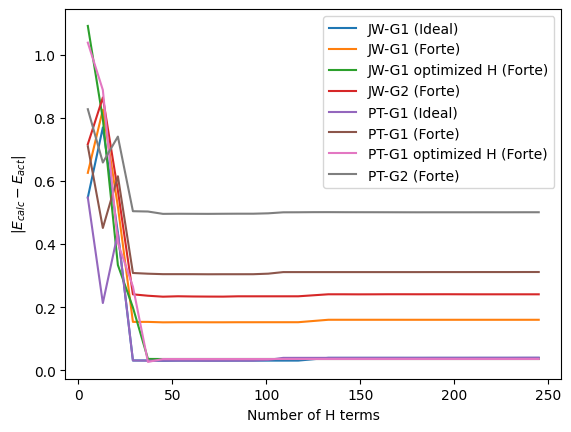

In [30]:
plt.plot(terms, energy_diffs_JW_G1, label="JW-G1 (Ideal)")
plt.plot(terms, energy_diffs_JW_G1_forte, label="JW-G1 (Forte)")
plt.plot(terms, energy_diffs_JW_G1_opt_forte, label="JW-G1 optimized H (Forte)")
plt.plot(terms, energy_diffs_JW_G2_forte, label="JW-G2 (Forte)")

plt.plot(terms, energy_diffs_PT_G1, label="PT-G1 (Ideal)")
plt.plot(terms, energy_diffs_PT_G1_forte, label="PT-G1 (Forte)")
plt.plot(terms, energy_diffs_PT_G1_opt_forte, label="PT-G1 optimized H (Forte)")
plt.plot(terms, energy_diffs_PT_G2_forte, label="PT-G2 (Forte)")

plt.ylabel(r"|$E_{calc} - E_{act}$|")
plt.xlabel(r"Number of H terms")

plt.legend()

plt.show()

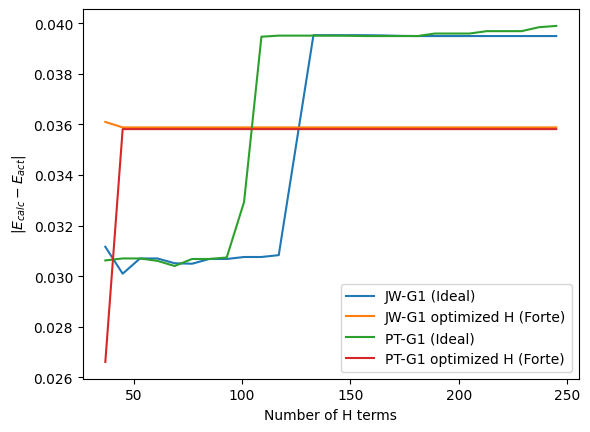

In [43]:
start = 4

plt.plot(terms[start:], energy_diffs_JW_G1[start:], label="JW-G1 (Ideal)")
# plt.plot(terms, energy_diffs_JW_G1_forte, label="JW-G1 (Forte)")
plt.plot(terms[start:], energy_diffs_JW_G1_opt_forte[start:], label="JW-G1 optimized H (Forte)")
# plt.plot(terms, energy_diffs_JW_G2_forte, label="JW-G2 (Forte)")

plt.plot(terms[start:], energy_diffs_PT_G1[start:], label="PT-G1 (Ideal)")
# plt.plot(terms, energy_diffs_PT_G1_forte, label="PT-G1 (Forte)")
plt.plot(terms[start:], energy_diffs_PT_G1_opt_forte[start:], label="PT-G1 optimized H (Forte)")
# plt.plot(terms, energy_diffs_PT_G2_forte, label="PT-G2 (Forte)")

plt.ylabel(r"|$E_{calc} - E_{act}$|")
plt.xlabel(r"Number of H terms")

plt.legend()

plt.show()

## Translate to IonQ Hardware